In [1]:
import sys
# Aggiungi il percorso della cartella che contiene utils.py a sys.path
sys.path.append('../utils')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.multioutput import MultiOutputRegressor
sns.set_theme(style='darkgrid')

from sklearn.model_selection import GridSearchCV, learning_curve

from sklearn.metrics import make_scorer
from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2
from joblib import dump

In [3]:
TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'SVR')
MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

In [4]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [5]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target_x,target_y,target_z
0,-0.917280,-0.712727,-0.989904,0.992819,0.993649,0.995543,0.711074,0.407645,-0.688548,0.616890,7.897453,-35.936382,21.077147
1,-0.858784,0.998755,-0.998396,0.999909,0.316503,-0.951897,-0.163139,0.980982,0.661759,-0.800155,-9.330632,19.901571,6.069154
2,-0.990441,0.958726,-0.998675,0.997216,0.987166,0.356483,-0.279689,0.599163,-0.684630,0.922901,14.849400,3.374090,19.667479
3,0.937117,0.984474,-0.612420,0.999812,0.728623,-0.539962,-0.165939,0.999352,-0.921444,-0.974766,-46.591854,13.734777,17.953600
4,-0.906628,-0.884567,-0.932487,0.941037,0.978134,0.998179,0.749606,-0.590599,-0.508268,0.691798,8.217500,-45.885254,14.894251


In [6]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #TODO split potenzialmente variabile?

# Create model

In [7]:
mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
multidim_r2_scorer = make_scorer(multidim_r2, greater_is_better=True)

scoring = {'MEE': mee_scorer, 'R2': multidim_r2_scorer, 'RMSE': rmse_scorer}

In [8]:
svr = svm.SVR()

model = MultiOutputRegressor(svr)

In [9]:
# Best parameters found
param_grid = {
    'svr__estimator__C': [100],
    'svr__estimator__coef0': [2],
    'svr__estimator__degree': [4],
    'svr__estimator__epsilon': [0.1],
    'svr__estimator__gamma': [0.1],
    'svr__estimator__kernel': ['poly']
}

'''
# Original param_grid
param_grid = [
    {
        'svr__estimator__kernel': ['linear'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['rbf'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['poly'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__degree': [2, 3, 4],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__coef0': [0, 1, 2],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    },
    {
        'svr__estimator__kernel': ['sigmoid'],
        'svr__estimator__C': [0.1, 1, 10, 100],
        'svr__estimator__gamma': [0.1, 0.01, 0.001],
        'svr__estimator__coef0': [0, 1, 2],
        'svr__estimator__epsilon': [0.01, 0.1, 1]
    }
]
'''

"\nparam_grid = [\n    {\n        'svr__estimator__kernel': ['linear'],\n        'svr__estimator__C': [0.1, 1, 10, 100],\n        'svr__estimator__epsilon': [0.01, 0.1, 1]\n    },\n    {\n        'svr__estimator__kernel': ['rbf'],\n        'svr__estimator__C': [0.1, 1, 10, 100],\n        'svr__estimator__gamma': [0.1, 0.01, 0.001],\n        'svr__estimator__epsilon': [0.01, 0.1, 1]\n    },\n    {\n        'svr__estimator__kernel': ['poly'],\n        'svr__estimator__C': [0.1, 1, 10, 100],\n        'svr__estimator__degree': [2, 3, 4],\n        'svr__estimator__gamma': [0.1, 0.01, 0.001],\n        'svr__estimator__coef0': [0, 1, 2],\n        'svr__estimator__epsilon': [0.01, 0.1, 1]\n    },\n    {\n        'svr__estimator__kernel': ['sigmoid'],\n        'svr__estimator__C': [0.1, 1, 10, 100],\n        'svr__estimator__gamma': [0.1, 0.01, 0.001],\n        'svr__estimator__coef0': [0, 1, 2],\n        'svr__estimator__epsilon': [0.01, 0.1, 1]\n    }\n]\n"

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

'''
Scales input data using RobustScaler with the formula: (X - median(X)) / IQR,
where IQR is the interquartile range (75th - 25th percentile). This scaler is
chosen for its robustness to outliers, utilizing the median rather than the mean.
It is particularly beneficial for algorithms that are sensitive to the scale of data,
like neural networks, where it promotes zero mean and unit variance, leading to faster
gradient descent convergence. It also improves algorithms based on distance measures
(e.g., K-nearest neighbors, hierarchical clustering) and those assuming data normality.
However, algorithms such as Random Forest, which do not rely on distance or data normality,
may not see as much benefit from scaling.

Parameters:
X_train (array-like): Input data to be scaled.

Returns:
scaled_data (array-like): Scaled version of X_train.
'''

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', model)
])

In [11]:
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='MEE',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END svr__estimator__C=100, svr__estimator__coef0=2, svr__estimator__degree=4, svr__estimator__epsilon=0.1, svr__estimator__gamma=0.1, svr__estimator__kernel=poly; total time= 1.6min
[CV] END svr__estimator__C=100, svr__estimator__coef0=2, svr__estimator__degree=4, svr__estimator__epsilon=0.1, svr__estimator__gamma=0.1, svr__estimator__kernel=poly; total time= 1.8min
[CV] END svr__estimator__C=100, svr__estimator__coef0=2, svr__estimator__degree=4, svr__estimator__epsilon=0.1, svr__estimator__gamma=0.1, svr__estimator__kernel=poly; total time= 1.9min
[CV] END svr__estimator__C=100, svr__estimator__coef0=2, svr__estimator__degree=4, svr__estimator__epsilon=0.1, svr__estimator__gamma=0.1, svr__estimator__kernel=poly; total time= 1.9min


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svr',
                                        MultiOutputRegressor(estimator=SVR()))]),
             n_jobs=-1,
             param_grid={'svr__estimator__C': [100],
                         'svr__estimator__coef0': [2],
                         'svr__estimator__degree': [4],
                         'svr__estimator__epsilon': [0.1],
                         'svr__estimator__gamma': [0.1],
                         'svr__estimator__kernel': ['poly']},
             refit='MEE',
             scoring={'MEE': make_scorer(mean_euclidean_error, greater_is_better=False),
                      'R2': make_scorer(multidim_r2),
                      'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False)},
             verbose=2)

In [12]:
results = pd.DataFrame(grid_search.cv_results_)
# results.to_csv('grid_search_SVR_results.csv', index=False)

In [13]:
'''
Quando si utilizza grid_search.best_score_ in scikit-learn e si ottiene un valore negativo,
ciò è tipicamente dovuto al fatto che scikit-learn trasforma alcune funzioni di scoring in modo 
che possano essere trattate come funzioni di "massimizzazione".
'''


best_params = grid_search.best_params_
best_index = grid_search.best_index_

mee = grid_search.best_score_
r2 = grid_search.cv_results_['mean_test_R2'][best_index]
rmse = grid_search.cv_results_['mean_test_RMSE'][best_index]

print('Best parameters:', best_params)
print('Best MEE score:', abs(mee))
print('R2:', abs(r2))
print('RMSE:', abs(rmse))

Best parameters: {'svr__estimator__C': 100, 'svr__estimator__coef0': 2, 'svr__estimator__degree': 4, 'svr__estimator__epsilon': 0.1, 'svr__estimator__gamma': 0.1, 'svr__estimator__kernel': 'poly'}
Best MEE score: 0.8040370246097828
R2: 0.9988637262107971
RMSE: 0.6485258152226461


In [14]:
final_model = grid_search.best_estimator_
final_model

Pipeline(steps=[('scaler', RobustScaler()),
                ('svr',
                 MultiOutputRegressor(estimator=SVR(C=100, coef0=2, degree=4,
                                                    gamma=0.1,
                                                    kernel='poly')))])

# Learning curve

In [15]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.1, 0.33, 0.55, 0.78, 1.],
    cv=5,
    n_jobs=-1,
    scoring=mee_scorer
)

In [16]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

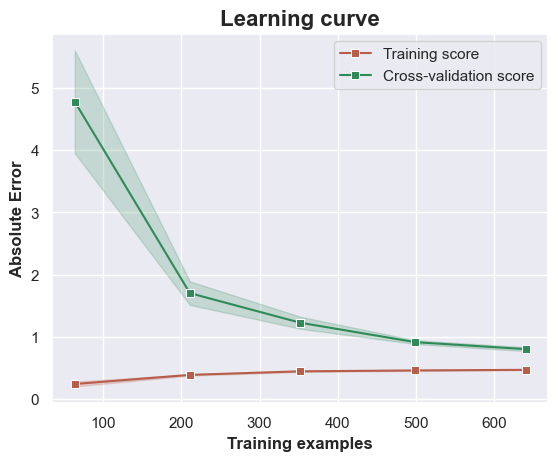

In [17]:
plt.figure()
plt.title('Learning curve', fontweight='bold', fontsize=16)
plt.xlabel('Training examples', fontweight='bold')
plt.ylabel('Absolute Error', fontweight='bold')
plt.grid(True)

color1 = sns.dark_palette((20, 60, 50), input='husl')[-1]
color2 = sns.dark_palette('seagreen')[-1]

# Filling the area around the mean scores to indicate variability of the model's performance
# The shaded area represents the range of scores (mean ± standard deviation) for each training set size
plt.fill_between(
    train_sizes, np.abs(train_scores_mean - train_scores_std),
                 np.abs(train_scores_mean + train_scores_std), alpha=0.2, color=color1
)
plt.fill_between(
    train_sizes, np.abs(validation_scores_mean - validation_scores_std),
                 np.abs(validation_scores_mean + validation_scores_std), alpha=0.2, color=color2
)

# Mean score lines for training and validation
sns.lineplot(x=train_sizes, y=np.abs(train_scores_mean), marker='s', color=color1, label='Training score')
sns.lineplot(x=train_sizes, y=np.abs(validation_scores_mean), marker='s', color=color2, label='Cross-validation score')
plt.legend(loc='upper right')

save_plot(plt, IMAGES_FOLDER, 'learning_curve')
plt.show()

# Plot temp map

In [18]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__estimator__C,param_svr__estimator__coef0,param_svr__estimator__degree,param_svr__estimator__epsilon,param_svr__estimator__gamma,param_svr__estimator__kernel,...,std_test_R2,rank_test_R2,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,split3_test_RMSE,split4_test_RMSE,mean_test_RMSE,std_test_RMSE,rank_test_RMSE
0,139.976586,63.147027,0.006629,0.00173,100,2,4,0.1,0.1,poly,...,0.000324,1,-0.777973,-0.654545,-0.645723,-0.606742,-0.557647,-0.648526,0.073219,1


In [19]:
epsilon_range = [0.01, 0.1, 1]
kernel_range = ['rbf', 'linear', 'poly', 'sigmoid']
C_range = [0.1, 1, 10, 100]
gamma_range = [0.001, 0.0001, 0.01, 0.1, 1]

In [20]:
def get_scores(epsilon, kernel, results, C_range, gamma_range):
    mask = (results['param_svr__estimator__kernel'] == kernel) & (results['param_svr__estimator__epsilon'] == epsilon)
    if kernel == 'linear':
        scores = np.abs(results.loc[mask, 'mean_test_MEE'].values)
        scores = np.tile(scores, (len(C_range), 1))
    else:
        filtered_scores = results.loc[mask, 'mean_test_MEE'].values
        expected_size = len(C_range) * len(gamma_range)
        scores = np.full((len(C_range), len(gamma_range)), np.nan)
        scores.flat[:min(filtered_scores.size, expected_size)] = np.abs(filtered_scores)
    return scores

/var/folders/ll/kv_3vwz11y3b1l9g2f0x8n_80000gn/T/ipykernel_73334/928216594.py:7: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  cax = ax.imshow(scores.reshape(len(C_range), -1), interpolation='nearest', cmap=plt.cm.hot)


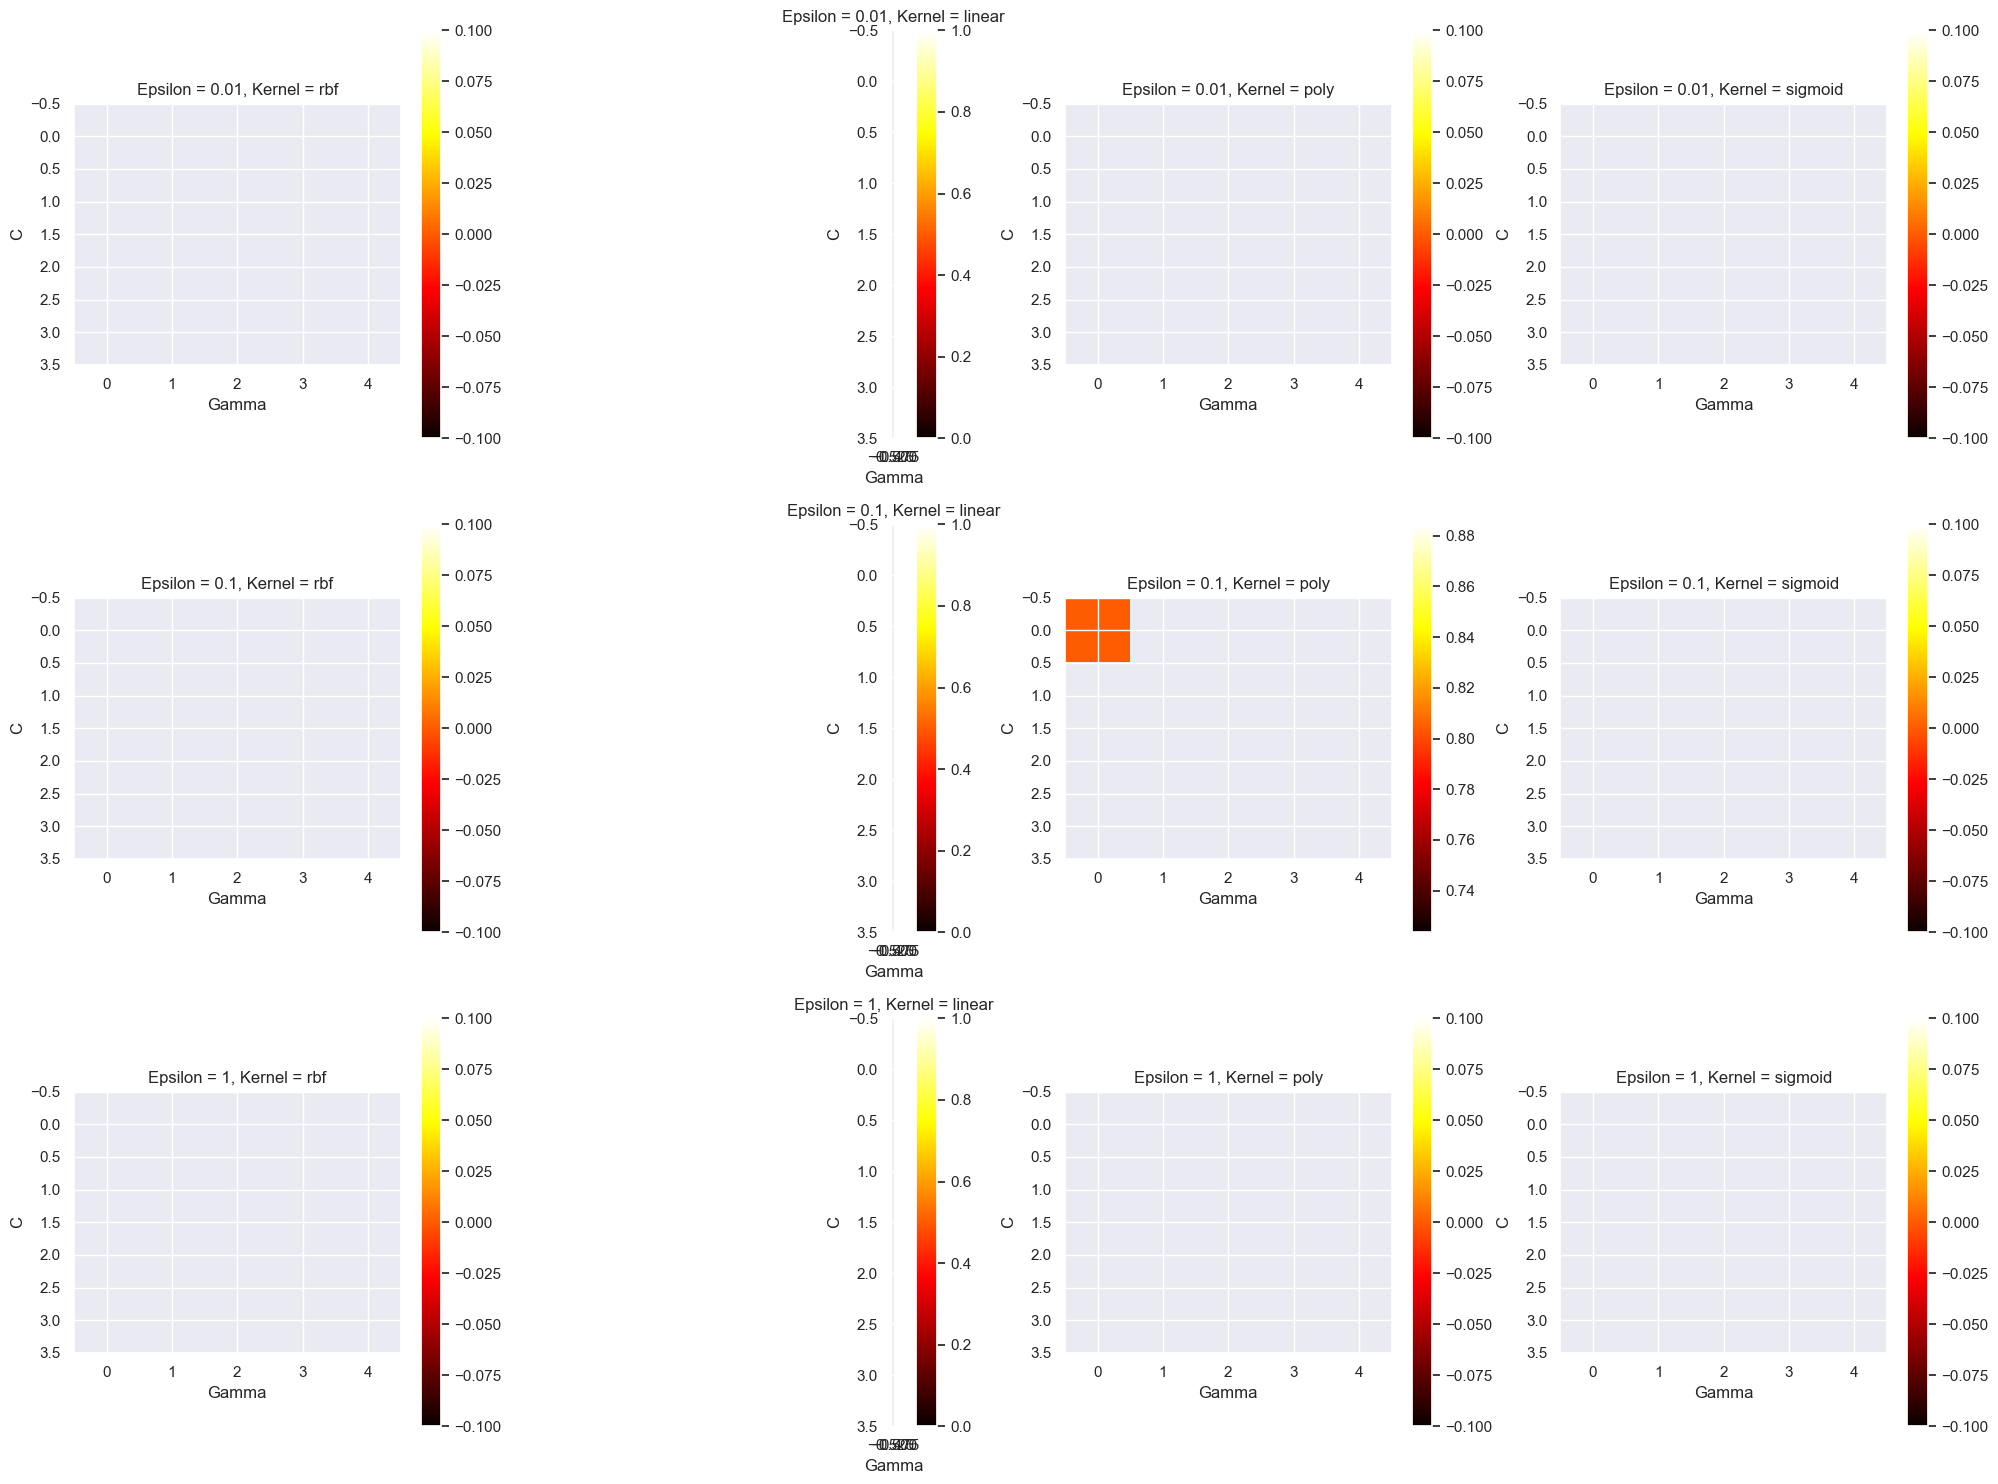

In [21]:
fig, axes = plt.subplots(len(epsilon_range), len(kernel_range), figsize=(20, 15))

for idx, epsilon in enumerate(epsilon_range):
    for kdx, kernel in enumerate(kernel_range):
        scores = get_scores(epsilon, kernel, results, C_range, gamma_range)
        ax = axes[idx, kdx]
        cax = ax.imshow(scores.reshape(len(C_range), -1), interpolation='nearest', cmap=plt.cm.hot)
        ax.set_title(f'Epsilon = {epsilon}, Kernel = {kernel}')
        ax.set_xlabel('Gamma')
        ax.set_ylabel('C')
        plt.colorbar(cax, ax=ax)

plt.tight_layout()
save_plot(plt, IMAGES_FOLDER, 'svr_parameter_performance_heatmaps')
plt.show()

# Test of the model

In [22]:
y_pred = final_model.predict(X_test)

mee = mean_euclidean_error(y_test, y_pred)
r2 = multidim_r2(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('MEE:', mee)
print('R2:', r2)
print('RMSE:', rmse)

MEE: 0.8322038235576552
R2: 0.9983672892765935
RMSE: 0.745102335035846


# Save model

In [23]:
model_path = os.path.join(MODEL_FOLDER, 'SVR_model.joblib')
dump(model, model_path, compress=3)

['../../trained_models/cup2023/SVR_model.joblib']